In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

/home/amigo/PyProj_2/env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv('features.csv', index_col='match_id')

df.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [3]:
#Проверка на наличие пропусков в признаках

def passed_values(df):
    d = {}
    for col in df.columns:
        if df[col].count() < df.shape[0]:
            #print('{} missed {}'.format(col, df.shape[0] - df[col].count())
            d[col] = df.shape[0] - df[col].count()
    return d

passed_values(df)

{'first_blood_time': 19553,
 'first_blood_team': 19553,
 'first_blood_player1': 19553,
 'first_blood_player2': 43987,
 'radiant_bottle_time': 15691,
 'radiant_courier_time': 692,
 'radiant_flying_courier_time': 27479,
 'radiant_first_ward_time': 1836,
 'dire_bottle_time': 16143,
 'dire_courier_time': 676,
 'dire_flying_courier_time': 26098,
 'dire_first_ward_time': 1826}

In [4]:
#Заполняем пропуски нулями
df.fillna(0, inplace=True)    

res_features = ['duration', 'radiant_win', 'tower_status_radiant',
                'tower_status_dire','barracks_status_radiant',
                'barracks_status_dire']

X_train = df.drop(res_features, axis=1)
y_train = df['radiant_win']

X_train.shape

(97230, 102)

### Gradient Boosting

In [5]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=241)

param = {'learning_rate': [0.2, 0.3, 0.4],
        'n_estimators': [100, 130, 140, 150, 160, 170],
         'max_depth': [2, 3]
        }

GBclf = GradientBoostingClassifier(random_state=241)

gs = GridSearchCV(GBclf, param, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=1)

gs.fit(X_train[:30000], y_train[:30000])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 10.8min finished


CPU times: user 23.3 s, sys: 381 ms, total: 23.6 s
Wall time: 10min 59s


In [6]:
# Печать лучших параметров
print('best score: {}\nparameters: {}'.format(round(gs.best_score_, 3), gs.best_params_))

best score: 0.73
parameters: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 170}


In [156]:
%%time

#Строим кривые обучения
GBclf_test = GradientBoostingClassifier(learning_rate=0.3, n_estimators=100,
                                        max_depth=2, random_state=241)
GBclf_test.fit(X_train[:30000], y_train[:30000])
    
res_train = []
for i, y_pred in enumerate(GBclf_test.staged_decision_function(X_train[:30000])):
    loss = roc_auc_score(y_train[:30000], y_pred)
    res_train.append(loss)

res_test = []
for i, y_pred in enumerate(GBclf_test.staged_decision_function(X_train[30000:60000])):
    loss = roc_auc_score(y_train[30000:60000], y_pred)
    res_test.append(loss)

CPU times: user 8.07 s, sys: 7.85 ms, total: 8.08 s
Wall time: 8.08 s


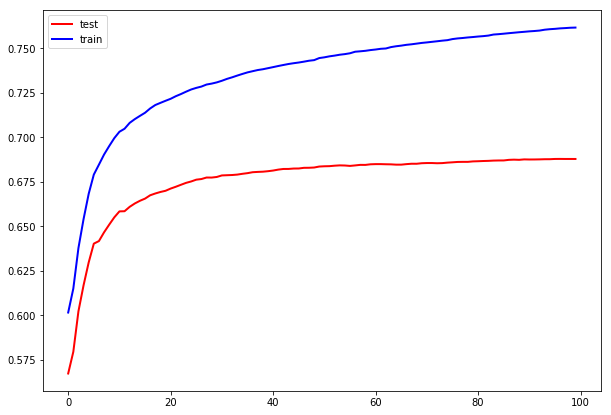

In [157]:
plt.figure(figsize=(10, 7))
plt.plot(res_test, 'r', linewidth=2)
plt.plot(res_train, 'b', linewidth=2)
plt.legend(['test', 'train'])

In [158]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=241)

GBclf = GradientBoostingClassifier(learning_rate=0.3, n_estimators=130,
                                        max_depth=2, random_state=241)

scores = cross_val_score(GBclf, X_train, y_train, scoring='roc_auc', cv=kf, verbose=1)

print('Качество финальной модели на ROC-AUC: ', round(scores.mean(), 3))

Качество финальной модели на ROC-AUC:  0.712
CPU times: user 2min 14s, sys: 440 ms, total: 2min 14s
Wall time: 2min 14s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


### Logistic Regression

In [159]:
X_train = df.drop(res_features, axis=1)
y_train = df['radiant_win']

In [160]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=241)

params_lg = {'C': [0.01, 0.1, 1, 10, 100]}
lg = LogisticRegression(random_state=241)

lg_grsch = GridSearchCV(lg, params_lg, n_jobs=-1, cv=kf, verbose=1)
lg_grsch.fit(X_train, y_train)

print('best score: {}\nbest params: {}'.format(lg_grsch.best_score_,
                                               lg_grsch.best_params_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.1s finished


best score: 0.5185025197984161
best params: {'C': 0.01}
CPU times: user 4.58 s, sys: 297 ms, total: 4.88 s
Wall time: 12.8 s


In [161]:
hero_cols = ['r1_hero' , 'r2_hero', 'r3_hero', 'r4_hero', 'r5_hero',
             'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

heroes = pd.unique(X_train[hero_cols].values.ravel())
print('Номера героев:\n', np.sort(heroes))

Номера героев:
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 109 110 112]


In [162]:
%%time

N = 112 #номер максимального героя
X_pick = np.zeros((X_train.shape[0], N))

#Cоздание мешка слов для персонажей
for i, match_id in enumerate(X_train.index):
    for p in range(5):
        X_pick[i, X_train.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, X_train.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

CPU times: user 37.5 s, sys: 116 ms, total: 37.7 s
Wall time: 37.7 s


In [163]:
print(X_train.shape, X_pick.shape)

(97230, 102) (97230, 112)


In [164]:
categ_ft = ['lobby_type', 'r1_hero' , 'r2_hero', 'r3_hero', 'r4_hero',
           'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

X_train = X_train.drop(categ_ft, axis=1)

In [165]:
#масштабируем признаки
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)

[[-2.54436416  1.40080818  1.52597175 ... -0.55115386  1.84600409
  -1.12149424]
 [-2.54045236  0.50131354 -0.08013929 ...  0.67817009  0.43778816
   0.04394713]
 [-2.53923104  0.50131354  0.1510701  ...  0.67817009  0.43778816
   0.49028637]
 ...
 [ 1.09874571  0.50131354  0.29226667 ...  0.67817009  0.43778816
  -0.20401912]
 [ 1.09895204 -0.39818111 -0.17368203 ...  0.67817009  0.43778816
  -0.87352799]
 [ 1.1026479  -0.39818111 -0.31840851 ... -0.55115386 -0.97042777
  -0.79913812]]


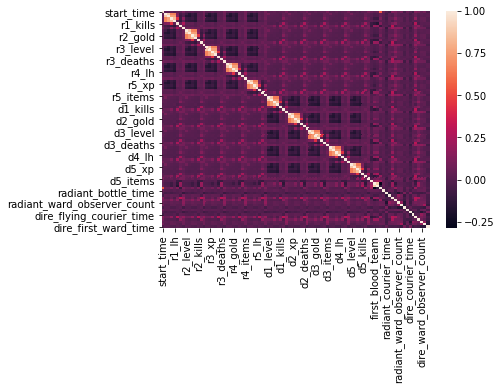

In [166]:
#Корелляция признаков

sns.heatmap(X_train.corr())

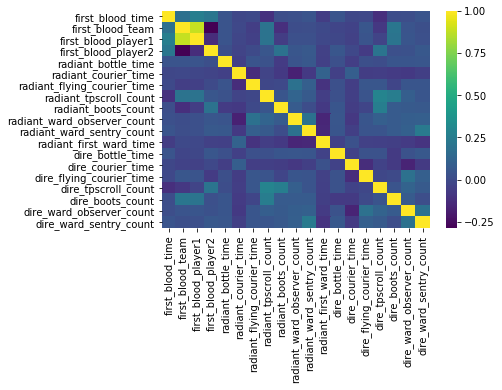

In [167]:
#Корелляция последних 20ти признаков
sns.heatmap(X_train[X_train.columns[71:90]].corr(), cmap='viridis')

In [169]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=241)

lg = LogisticRegression(C=0.01)
scores = cross_val_score(lg, X_train_scaled, y_train, cv=kf, verbose=1)

print('Оценка на масштабированных данных: ', round(scores.mean(), 3))

Оценка на масштабированных данных:  0.655
CPU times: user 15.8 s, sys: 1.21 s, total: 17 s
Wall time: 16 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.0s finished


In [170]:
X_train_scaled_heros = np.hstack((X_train_scaled, X_pick))

In [171]:
%%time

kf = KFold(n_splits=5, shuffle=True, random_state=17)

lg = LogisticRegression(C=0.01)
scores = cross_val_score(lg, X_train_scaled_heros, y_train, scoring='roc_auc', cv=kf, verbose=1)

print('Оценка на данных с мешком слов: ', round(scores.mean(), 3))

Оценка на данных с мешком слов:  0.752
CPU times: user 24.2 s, sys: 959 ms, total: 25.2 s
Wall time: 24.2 s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.2s finished


In [ ]:
#Лучшая оценка на ROC-AUC: 0,752